# Dynamic Programming Tracker for Hands
Implementation of  [Dreuw06 - Tracking Using Dynamic Programming
for Appearance-Based Sign Language Recognition](http://thomas.deselaers.de/publications/papers/dreuw_fg06.pdf)

## Imports

In [18]:

%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import os
import numpy as np
import skimage.io
import skimage
from scipy import ndimage
from skimage.draw import circle_perimeter_aa,circle
from skimage import transform


import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as anim

from scipy.stats import multivariate_normal
import numba
import skvideo.io
import skvideo.datasets

import itertools

import scoring
import util




## Configuration


In [14]:
test_path='test_data/All_Blacks.5846.main_glosses.mb.r480x360.mp4'
test_path='test_data/_1276_small_3.mov'
output_path='tmp/'
filename =os.path.basename(test_path)
tracked_video_path= os.path.join(output_path,filename)
debug_video_path=os.path.join(output_path,"_debug".join(os.path.splitext(filename)))
data = skvideo.io.ffprobe(test_path)['video']
rate = data['@r_frame_rate']
video = skvideo.io.vread(test_path).astype(float)

print("Original video shape: %s" % str(video.shape))
video=video[0::2,:,:,:]
util.video_rgb_to_hsv(video)

T,h,w,c=video.shape

new_size=(320,320)
video_original=video
video=np.zeros((T,new_size[0],new_size[1],c))
for t in range(T):
    video[t,:,:,:] = transform.resize(video_original[t,:,:,:], new_size, order=1)

T,h,w,c=video.shape

print("Resulting video shape: %s" % str(video.shape))

Original video shape: (500, 312, 324, 3)


/home/facuq/dev/dpt/.env/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Resulting video shape: (250, 320, 320, 3)


In [ ]:
def jump_penalty_euclidean(p1,p2):
  d=p1-p2
  return np.sum(d**2)
def skin_config_asllvd():
    mu_hsv=np.array([20.0,35.0,73.0])/255.0
    #mu_rgb=np.array([176,134,112])
    cov=np.array([0.3,0.5,10])
    return mu_hsv,cov
def skin_config_boston():
    mu_hsv=np.array([357,56.0,85.0])/255.0
    #mu_rgb=np.array([176,134,112])
    cov=np.array([0.3,0.7,15])
    return mu_hsv,cov

mu,cov=skin_config_asllvd()
mu,cov=skin_config_boston()

movement_weight=0.2
optical_flow_weight=0.5
scorers=[scoring.manhattan_movement_score,lambda video:scoring.skin_pixel_scorer(video,mu,cov),scoring.optical_flow_movement_score]
scorers_labels=['manhattan_movement','pixel','optical_flow']
scorers_weights=[movement_weight,1-movement_weight-optical_flow_weight,optical_flow_weight]
local_score,scores=scoring.calculate_local_score(video,scorers,scorers_weights)

(249, 320, 320)
Movement score treshold: 0.024699
Pixel score treshold: 0.012768


## Test model

In [16]:
class DPTracker:  

  def __init__(self):
    pass

  def backtrack_path(self,backtracking_path,score):
    Tm,h,w,dim_indices=backtracking_path.shape
    T=Tm+1
    path=np.zeros((T,2),dtype=int) # 2 => (x,y)
    best_index_last_frame = np.argmax(score[-1,:,:])
    x,y= np.unravel_index(best_index_last_frame , score[-1,:,:].shape)
    path[-1,:]=np.array([x,y])
    for t in reversed(range(T-1)):
      x,y= tuple(path[t+1,:])
      path[t, :] = backtracking_path[t,x,y,:]
    return path

  @numba.jit
  def track(self,video,local_score,jump_penalty_matrix):
    video = ndimage.gaussian_filter(video, sigma=(0, 2, 2, 0), order=0)
    T,h,w,c=video.shape
    self.backtracking_path=np.zeros((T-1,h,w,2),dtype=int) # 2 => (x,y) for T-1
    self.score=np.zeros((T,h,w))
    n=int((jump_penalty_matrix.shape[0]-1)/2)
    n2=n+1
    

    self.score[0,:,:]=local_score[0,:,:]
    self.local_score =local_score
        
    initial_values=np.zeros((h,w,2))

    for i in range(h):
      for j in range(w):
        initial_values[i,j,:]=np.array([i,j])
    self.backtracking_path[:,:,:,:]=initial_values
    
    print("Calculating score for frame:")
    for t in range(1,T):
      print("%d/%d - " % (t,T-1), end="")
      for i in range(n, h-n):
        for j in range(n, w-n):
          neighbourhood_score=self.score[t-1,i-n:i+n2,j-n:j+n2]
          previous_score=neighbourhood_score-jump_penalty_matrix
            
          index=np.argmax(previous_score)
          best_score=previous_score.flat[index]
          relative_x,relative_y=np.unravel_index(index, jump_penalty_matrix.shape)
          x = i + relative_x - n
          y = j + relative_y - n
          self.backtracking_path[t-1, i, j, 0] =x
          self.backtracking_path[t-1, i, j, 1] =y
          self.score[t,i,j]=self.local_score[t,i,j]+best_score #np.mean(previous_score)
    self.path=self.backtrack_path(self.backtracking_path,self.score)
    
    return self.path

def generate_jump_penalty_matrix(jump_penalty, neighbourhood):
    n=neighbourhood*2+1
    matrix=np.zeros((n,n))
    center=np.array([neighbourhood,neighbourhood])
    for i in range(n):
      for j in range(n):
        position=np.array([i,j])
        matrix[i,j]=jump_penalty(center,position)
    return matrix

neighbourhood_size=25
jump_penalty_weight=0.0003
jump_penalty_matrix=jump_penalty_weight * generate_jump_penalty_matrix(jump_penalty_euclidean,neighbourhood_size)


tracker=DPTracker()
track_result=tracker.track(video,local_score,jump_penalty_matrix)

print("Tracking coordinates")
print(track_result.T)


Calculating score for frame:
1/249 - 2/249 - 3/249 - 4/249 - 5/249 - 6/249 - 7/249 - 8/249 - 9/249 - 10/249 - 11/249 - 12/249 - 13/249 - 14/249 - 15/249 - 16/249 - 17/249 - 18/249 - 19/249 - 20/249 - 21/249 - 22/249 - 23/249 - 24/249 - 25/249 - 26/249 - 27/249 - 28/249 - 29/249 - 30/249 - 31/249 - 32/249 - 33/249 - 34/249 - 35/249 - 36/249 - 37/249 - 38/249 - 39/249 - 40/249 - 41/249 - 42/249 - 43/249 - 44/249 - 45/249 - 46/249 - 47/249 - 48/249 - 49/249 - 50/249 - 51/249 - 52/249 - 53/249 - 54/249 - 55/249 - 56/249 - 57/249 - 58/249 - 59/249 - 60/249 - 61/249 - 62/249 - 63/249 - 64/249 - 65/249 - 66/249 - 67/249 - 68/249 - 69/249 - 70/249 - 71/249 - 72/249 - 73/249 - 74/249 - 75/249 - 76/249 - 77/249 - 78/249 - 79/249 - 80/249 - 81/249 - 82/249 - 83/249 - 84/249 - 85/249 - 86/249 - 87/249 - 88/249 - 89/249 - 90/249 - 91/249 - 92/249 - 93/249 - 94/249 - 95/249 - 96/249 - 97/249 - 98/249 - 99/249 - 100/249 - 101/249 - 102/249 - 103/249 - 104/249 - 105/249 - 106/249 - 107/249 - 108/249 -

## Save output

In [11]:

def draw_tracked(video,track_result):
  T,h,w,c = video.shape
  image_shape=(h,w)
  radius=5
  color=np.array([255.0,0,0])
  for t in range(T):
    x,y=tuple(track_result[t,:])
    if (x-radius>=0) and (x+radius<h) and (y-radius>=0) and (y+radius<w):
      rr,cc=circle(x,y,radius,shape=image_shape)
      video[t,rr,cc,:]=color
  return video


def generate_debug_video(video,scores,labels,output_path):
#   FFMpegWriter= anim.writers['ffmpeg']
  metadata=dict(title="Output")
#   writer=FFMpegWriter(fps=6,bitrate=16384*2,metadata=metadata)

  columns=int(np.ceil(len(scores)/2))+1
  f,axes=plt.subplots(2,columns,dpi=100)
  axes =list(itertools.chain.from_iterable(axes))
  image_ax=axes[0]
  f.set_size_inches(10,10, True)
  T,h,w,c=video.shape
  base_file,ext=os.path.splitext(output_path)
  if not os.path.exists(base_file):
    os.mkdir(base_file)
#   with writer.saving(f,debug_video_path,T):
  cbars=[]
  ranges=[]
  for s in range(len(scores)):
    ranges.append( (0,np.max(scores[s])) )
  for t in range(T):
    plt.suptitle("Frame %d/%d" % (t,T-1))
    image_ax.cla()
    plot=image_ax.imshow(video[t,:,:,:])
    
    for s in range(len(scores)):
      ax=axes[s+1]
      ax.cla()
      ax.set_title(labels[s],fontsize=10)
    
      data=scores[s][t,:,:]
      vmin,vmax=ranges[s]
      plot=ax.imshow(data,cmap='gray',vmin=vmin,vmax=vmax)  
      if t==0:
        cbar=f.colorbar(plot, ax=ax)
        cbar.ax.tick_params(labelsize=10)
        cbar_ticks = np.linspace(vmin,vmax, num=10, endpoint=True)
        cbar.set_ticks(cbar_ticks)
        cbars.append(cbar)
#       plot.set_clim([data.min(), data.max()])
#       cbar_ticks = np.linspace(data.min(), data.max(), num=10, endpoint=True)
#       cbars[s].set_ticks(cbar_ticks) 
#       plot.autoscale()
    a='%s/%03d.png' % (base_file,t)
    plt.savefig(a)
#       writer.grab_frame()

tracked_video=np.copy(video)
util.video_hsv_to_rgb(tracked_video)
tracked_video=draw_tracked(tracked_video,track_result)
tracked_video=tracked_video.astype('short')
show_scores=[local_score,tracker.score]+scores
show_scores_label=['local','global']+scorers_labels
generate_debug_video(tracked_video, show_scores,show_scores_label,debug_video_path)

# skvideo.io.vwrite(tracked_video_path, tracked_video, outputdict={
#   '-vcodec': 'libx264',
#   '-pix_fmt': 'yuv420p',
#   '-r': rate,
# })
plt.close("all")

(250,)


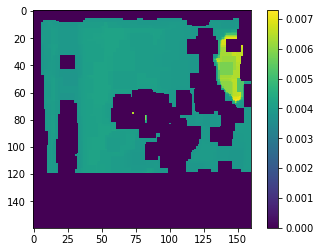

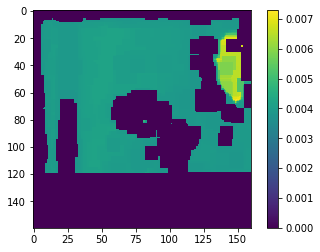

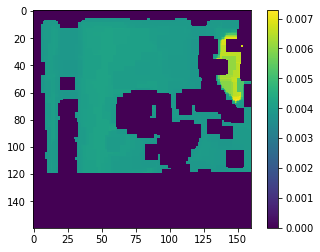

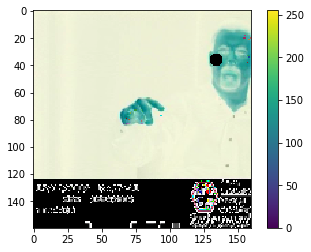

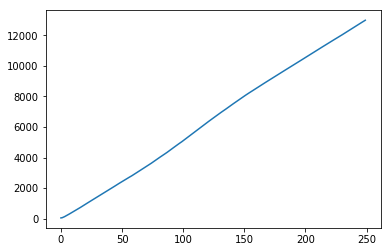

In [12]:
score=tracker.local_score
plt.imshow(score[T-2,:,:])
plt.colorbar()
plt.figure()
plt.imshow(score[T-3,:,:])
plt.colorbar()
plt.figure()
plt.imshow(score[T-4,:,:])
plt.colorbar()
plt.figure()
plt.imshow(tracked_video[T-1,:,:,:])
plt.colorbar()
plt.figure()
mean_scores=np.sum(tracker.score,axis=(1,2))
print(mean_scores.shape)
plt.plot(mean_scores)
plt.show()
